In [ ]:
#%% Load Modules
#startup_file='init_python.py'
#exec(open(startup_file).read())
#from matplotlib.patches import Rectangle

import numpy as np
import scipy as scp
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import animation,cm,rc,colors
from scipy.optimize import curve_fit

In [ ]:
#DEFINITION OF NEW FIGURE COMMAND - TAKEN FROM SIMON THALABARD

def newfig(a=1,b=1,figheight=12,aspectratio=0.75,fontsize=34,**kwargs):
    rc('legend', frameon=False,fancybox=False,shadow=False,fontsize=28,loc='best')
    rc('lines', linewidth=1)
    font = {'family':'serif','size':fontsize}
    rc('font',**font)
    rc('text', usetex=True)
    rc('xtick',labelsize=fontsize)
    rc('ytick',labelsize=fontsize)
    rc('savefig',format='pdf')
    return plt.subplots(a,b,figsize=(b*figheight,a*figheight*aspectratio),clear=True,tight_layout=True,**kwargs)



# Universal Functions

In [29]:
# DEFINE SPECTRUM FITTING FUNCTIONS

# full Rayleigh-Jeans
def RayleighJeans_function(x,a):
    return 1.0 /( (x/a) + 1.0)

# Rayleigh-Jeans right front
def RayleighJeans_right_function(x,a):
    return a/x

# constant fit
def constant_function(x,a):
    return a

# log fit
def log_direct(x,a,b):
    return a/np.log(b/x)**(-1.0/3.0)


# exp fit
def exp_function(x,a,b):
    return a * x**(1.0/3.0) * np.exp(-b*x**(1.0/3.0))

# exp2 fit
def exp2_function(x,a,b):
    return a * x**(-2.0/3.0) * np.exp(b*x**(1.0/3.0))

# exp3 fit
def exp3_function(x,a,b):
    return a * x * np.exp(-b*x**(3.0/4.0))

# exp4 fit
def exp4_function(x,a,b):
    return a * x**(-1.0) * np.exp(b*x**(3.0/4.0))


In [ ]:
# CONVERT FROM K TO OMEGA REPRESENTATION

def convert_k_to_omega(k,n_k):

    n_omega = n_k[1:]/(2.0*k[1:]) 	# n_1d/2k = n_omega 1d sepctrum in freq space
    omega = k[1:]**2.0	
    
    return omega, n_omega

In [ ]:
# ESTIMATE MU AND T - separate 
def estimate_mu_T(omega,n_omega):
    
	# constant fit at low omega = T/mu = normValue
 
	normValue, pcov = curve_fit(constant_function, omega[klow_min:klow_max], n_omega[klow_min:klow_max])
 
	##normalisationValue = np.max(n_omega[0:(3*kf//4)])				#Simon's computation of nomralisationValue =  maxValue
	##normalisationValue = np.mean(n_omega[0:kmax_low])			#Alternative computation of nomralisationValue =  meanValue
	

	# this is T estimate from Rayleigh-Jeans fit	
	T, pcov = curve_fit(constant_function, omega[khigh_min:khigh_max], omega[khigh_min:khigh_max] *n_omega[khigh_min:khigh_max])
	
	mu = T / normValue
    
	return mu, T


def estimate_mu_T_RJ(omega,n_omega):
    
	# RJ fit from k_low to khigh_max
 
	normValue, pcov = curve_fit(constant_function, omega[klow_min:klow_max], n_omega[klow_min:klow_max])
 
	##normalisationValue = np.max(n_omega[0:(3*kf//4)])				#Simon's computation of nomralisationValue =  maxValue
	##normalisationValue = np.mean(n_omega[0:kmax_low])			#Alternative computation of nomralisationValue =  meanValue
	

	# this is the mu estimate from Rayleigh-Jeans fit	
	mu, pcov = curve_fit(RayleighJeans_function, omega[klow_min:khigh_max], n_omega[klow_min:khigh_max]/normValue)
	
	T = mu * normValue
    
	return mu, T


# ESTIMATE MU AND T
def estimate_mu_T_extrap(omega,n_omega, omega_plus):
    
	# constant fit at low omega = T/mu = normValue
 
	normValue, pcov = curve_fit(constant_function, omega[klow_min:klow_max], n_omega[klow_min:klow_max])
 
	##normalisationValue = np.max(n_omega[0:(3*kf//4)])				#Simon's computation of nomralisationValue =  maxValue
	##normalisationValue = np.mean(n_omega[0:kmax_low])			#Alternative computation of nomralisationValue =  meanValue
	

	# this is T estimate from log-corrected fit	
	T, pcov = curve_fit(constant_function, omega[khigh_min:khigh_max], np.log((omega_plus/omega[khigh_min:khigh_max]))**(-1.0/3.0)*omega[khigh_min:khigh_max] *n_omega[khigh_min:khigh_max])
	
	mu = T / normValue
    
	return mu, T


# ESTIMATE T for right log front
def estimate_T_log_right(omega,n_omega, omega_plus):
    

 	# this is T estimate from log-corrected fit	
	T, pcov = curve_fit(constant_function, omega[klog_min:klog_max], n_omega[klog_min:klog_max] * omega[klog_min:klog_max] * np.log( omega_plus/omega[klog_min:klog_max])**(-1.0/3.0)  )   
 
    
	return T

# ESTIMATE T for right log front
def estimate_T_log_right2(omega,n_omega,time):
    

 	# this is T estimate from log-corrected fit	
	[T,c], pcov = curve_fit(log_direct, omega[klog_min:klog_max], n_omega[klog_min:klog_max] * omega[klog_min:klog_max], p0=[1,1.e10])   
 
    
	return T,c

In [102]:
# FIND PROPAGATING FRONT FREQUENCY

def find_omega_plus(x, y):  # x = omega, y = n_omega
    threshold = 1.e-4
   
    i = len(y)-1           # end index of y array
    val = x[i]*y[i]              # record value. should be close to zero - this is for the compensated spectrum omega * n_omega
    ##val = y[i]
    while val < threshold:
        i = i - 1           # go through array backwards
        val = x[i]*y[i]     # measured using compensated spectrum
        #val = y[i]         # or measured using wave action spectrum (non-compensated)
        if i==0:
            val = 1.0
    return x[i]                    # once value goes over threshold, return the value of eta at index


def find_eta_plus(x, y):  # x = eta, y = eta * phi
    threshold = 1.e-10
    i = len(y)-1           # end index of y array
    val = y[i]              # record value. should be close to zero
    while val < threshold:
        i = i - 1           # go through array backwards
        val = y[i]
       
        if i==0:
            val=1
    return eta[i]                    # once value goes over threshold, return the value of eta at index


# FREE DYNAMICS

In [34]:
# DEFINE PARAMETERS FROM SIMULATION 

N_ensemble = 3    #number of ensembles created for freely evoling sumilations. Used for averaging data

file_start = 1  #define the start/end files for plotting
file_end = 150

spectrum_freq = 10
data_freq = 1

dt = 0.005  #time between files (OLD: 0.5 factor due to change in equation). Simulation time = dt * filenumber

#initial injection scale in k- and freq-space
kf = 128
wf = kf**2.0


L = 2.0*np.pi   #box size
N = 2048        #number of spatial grid points in data

#fluxes defined from initial forcing
wave_action_flux = 2.0 * 32.12
energy_flux = 2.0 * 8.41969e6

#fit regions for T/mu
klow_min = 1
klow_max = 4

#fit regions for T/\omega
khigh_min = 64
khigh_max = 128


wave_action = 2.388319e-7

In [35]:

#DECALRE DATA ARRAYS FOR ANALYSIS

n_k = np.zeros(N)
temp = np.zeros(file_end-file_start+1)
mu =  np.zeros(file_end-file_start+1)
time = np.zeros(file_end-file_start+1)
omega_plus = np.zeros(file_end-file_start+1)


time_data = []
mu_data = []
temp_data = []
omega_plus_data = []
condensate_data = []


fig1, axs1 = newfig(1, 2)

fig2, axs2 = newfig(1, 2)

fig3, axs3 = newfig(1, 2)

for file_num in range(file_start,file_end+1,data_freq):	#loop over data, every 25 files

	time = file_num * dt		# define simulation time
 
	time_data.append(time)
 
	n_k = 0.0
	
	#average over ensembles
	for ensemble_num in range(0,N_ensemble,1):
		filename = './Selfsimilar_data_May2024/Free_N=2048_a=1p5em2/ensemble_%.1d/output/spectrum.%.6d' % (ensemble_num,file_num);
		data = np.loadtxt(filename)
		n_k += data[:,1]

	n_k /= N_ensemble   # this is the 2d spectrum  
	k = data[:,0]		


	#filename = './Free_N=2048_a=1p5em2/output/spectrum.%.6d' % (file_num);    
	#data = np.loadtxt(filename)
	
	#n_k = data[:,1] 
	#k = data[:,0]		

	omega, n_omega = convert_k_to_omega(k,n_k)


	if file_num == file_start:			# compute total energy and wave action from initial file
		total_wave_action = np.sum(n_k)
		total_energy = 0.5 * np.sum(k * k * n_k)

	#calculate omega_plus
	omega_plus = find_omega_plus(omega, n_omega)

	omega_plus_data.append(omega_plus)

	#calculate mu and temp
	mu, temp = estimate_mu_T(omega, n_omega)

	mu_data.append(mu)
	temp_data.append(temp)
	condensate_data.append(n_k[0])

	

	##eta = omega * time**(- 1.0 / 3.0)
	##phi = n_omega * time**( 2.0 / 3.0)
	eta = omega /mu
	phi = n_omega * mu / temp

	if(file_num % spectrum_freq == 0):
		axs1[0].plot(omega, n_omega, linewidth=0.5,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))    						# plots the wave action spectrum (not rescaled)					
	
		axs1[1].plot(eta, phi, linewidth=0.5,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))					# plots the re-scaled wave action spectrum
	
axs1[0].plot(omega, n_omega, linewidth=2,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))										# plots the wave action spectrum (not rescaled)	

axs1[1].plot(eta, phi, linewidth=2,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))							# plots the re-scaled wave action spectrum

	
Gibbs = (temp/mu) / (1.0 + (omega/mu))																							# define theoretical Gibbs solution
axs1[0].plot(omega[:], Gibbs[:],linewidth=3,label=r'$Gibbs$', color='black', linestyle='--')									# plots the theoretical gibbs solution on wave action spectrum


initial=0.0*omega
initial[kf-2:kf+2]=0.0001*2*np.pi
axs1[0].plot(omega, initial, linewidth=2,c='firebrick')																			# plot the initial spectrum on wave action spectrum


#axs1.annotate(text=r'Gibbs',xy=(1.1,2.e-2),c='k')
axs1[0].annotate(text='$t=0$',xy=(wf-120000,1e-3),c='firebrick')
axs1[0].grid()
axs1[0].set_xlabel(r'$\omega$')
axs1[0].set_ylabel(r'$N(\omega,t)$')
axs1[0].set_yscale('log')
axs1[0].set_xscale('log')
axs1[0].set_xlim(1,(1024*1.5)**2)
axs1[0].set_ylim(1.e-10,1.e0)
#axs1.legend(loc='best', ncol=2)
axs1[0].set_title('(a)',loc='left',pad=24)






#fig1.tight_layout()

#fig1.savefig('spectrum_decay.pdf')


##################################################################################################################
eta = np.arange(1.e-5,1.e5,0.01)
Gibbs_fit = 1.0 / (eta+1.0)
axs1[1].plot(eta, Gibbs_fit,linewidth=3,label=r'$Gibbs$', color='black', linestyle='--')

#Extrap_fit = 1.0 / (eta*np.log(omega_plus/(mu*eta))**-0.33+1.0)
#axs2.plot(eta, Extrap_fit,linewidth=3,label=r'$Extrap$', color='red', linestyle='--')

#axs2.annotate(text=r'Anomalous Gibbs: $\frac{1}{\eta+1}$',xy=(1.1e-5,2.e0),c='k')
#axs2.annotate(text='$\leftarrow f_0$',xy=(wf,1e-4),c='firebrick')
axs1[1].grid()
axs1[1].set_xlabel(r'$\eta:=\omega/\mu(t)$')
axs1[1].set_ylabel(r'$\phi:=(\mu/T)N(\omega,t)$')
axs1[1].set_yscale('log')
axs1[1].set_xscale('log')
#axs2.set_xlim(1e-5,1e4)
axs1[1].set_ylim(1.e-8,1.e1)
#axs1.legend(loc='best', ncol=2)

axs1[1].set_title('(b)', loc='left', pad= 24)

fig1.tight_layout()

fig1.savefig('spectrum_free.pdf')


##################################################################################################################
#fitting for t  dt = 0.005
 #t=0.15 - 0.6

tlow = 30
thigh = 120 

# plot mu vs t

td = np.array(time_data)
mud = np.array(mu_data)
opd = np.array(omega_plus_data)
tempd = np.array(temp_data)
cd = np.array(condensate_data)

[c1,c2], pcov = curve_fit(exp_function,td[tlow:thigh], mud[tlow:thigh,0])

print('c1 = ', c1, ' c2 = ', c2)
axs2[0].scatter(td, mud,linewidth=3, color='b', linestyle='-')
#c1= 10000.0  # fitting for c1* t^{1/3} * exp( -c2 * t^{1/3})
#c2= 5.0
axs2[0].plot(time_data, c1*np.array(time_data)**(1.0/3.0) * np.exp(-c2* np.array(time_data)**(1.0/3.0)),linewidth=3,label=r'$c_1 t^{1/3}e^{-c_2 t^{1/4}}$', color='black', linestyle='--')


#axs2[0].plot(td, opd / ( np.exp(total_wave_action / tempd[:,0]) -1.0) ,linewidth=3,label=r'$test$', color='red', linestyle='--')





c, pcov = curve_fit(constant_function,td[tlow:thigh], td[tlow:thigh]**(1.0/3.0)*tempd[tlow:thigh,0])
print('c = ', c)
# plot for T vs t
axs2[1].scatter(time_data, temp_data,linewidth=3, color='r', linestyle='-')
#c=2.e-1  # fitting for c* t^{-1/3}
axs2[1].plot(time_data, c*np.array(time_data)**(-1.0/3.0),linewidth=3,label=r'$c_1 t^{-1/3}$', color='black', linestyle='--')



axs2[0].grid()
#axs2.set_xlabel(r'$\eta:=\omega/\mu(t)$')
axs2[0].set_ylabel(r'$\mu$')
axs2[0].set_xlabel(r'$t$')
axs2[0].set_yscale('log')
#axs2[0].set_xlim(1e-2,1e0)
#axs2[0].set_ylim(1e-2,1e0)
axs2[0].legend(loc='best', ncol=2)
axs2[0].set_title('(a)', loc='left',pad=24)

axs2[1].grid()
axs2[1].set_ylabel(r'$T$')
axs2[1].set_xlabel(r'$t$')
axs2[1].set_xscale('log')
axs2[1].set_yscale('log')
axs2[1].set_xlim(1e-2,1.e0)
axs2[1].set_ylim(1e-2,1e0)
axs2[1].legend(loc='best', ncol=2)
axs2[1].set_title('(b)', loc='left',pad=24)
fig2.tight_layout()
fig2.savefig('mu_T_free.pdf')


##################################################################################################################

# plot for omega_+ vs t
axs3[0].scatter(td, opd,linewidth=3, color='g', linestyle='-')



c, pcov = curve_fit(constant_function,td[tlow:thigh], td[tlow:thigh]**(-1.0/3.0)*opd[tlow:thigh])
print('c = ', c)


#c= 5.e4		# fitting for c * t^{1/3}
axs3[0].plot(td, c*np.array(td)**(1.0/3.0),linewidth=3,label=r'$c_1 t^{1/3}$', color='black', linestyle='--')






# plot N(omega =0)  vs t
axs3[1].scatter(time_data, condensate_data,linewidth=3, color='orange', linestyle='-')




[c1,c2], pcov = curve_fit(exp2_function,td[tlow:thigh], cd[tlow:thigh])

print('c1 = ', c1, ' c2 = ', c2)

#c1= 0.000001		# fitting for c * t^{-2/3} * Exp(c2 * t^{1/3})
#c2= 10.0
axs3[1].plot(td, c1*np.array(td)**(-2.0/3.0)*np.exp(c2 * np.array(td)**(1.0/3.0)),linewidth=3,label=r'$c_1t^{-2/3}e^{c_2 t^{1/3}}$', color='black', linestyle='--')




axs3[0].grid()
axs3[0].set_ylabel(r'$\omega_+$')
axs3[0].set_xlabel(r'$t$')
axs3[0].set_xscale('log')
axs3[0].set_yscale('log')
axs3[0].set_xlim(1e-2,1.e-0)
axs3[0].set_ylim(1.e5,1.e7)
axs3[0].legend(loc='best', ncol=2)
axs3[0].set_title('(a)', loc='left',pad=24)

axs3[1].grid()
axs3[1].set_ylabel(r'$N_{\omega=0}$')
axs3[1].set_xlabel(r'$t$')
axs3[1].set_xscale('log')
axs3[1].set_yscale('log')
axs3[1].set_xlim(1e-2,1e-0)
axs3[1].set_ylim(1.e-8,1.e-2)
axs3[1].legend(loc='best', ncol=2)
axs3[1].set_title('(b)', loc='left',pad=24)
fig3.tight_layout()

fig3.savefig('parameters_free.pdf')


FileNotFoundError: ./Selfsimilar_data_May2024/Free_N=2048_a=1p5em2/ensemble_0/output/spectrum.000001 not found.

Error in callback <function _draw_all_if_interactive at 0x729a86b88f40> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error ../504043b560c96a991b751ca17b4b51bb.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../504043b560c96a991b751ca17b4b51bb.tex
LaTeX2e <2023-11-01> patch level 1
L3 programming layer <2024-01-22>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2023/05/17 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.8 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on 504043b560c96a991b751ca17b4b51bb.log.




RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error ../504043b560c96a991b751ca17b4b51bb.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../504043b560c96a991b751ca17b4b51bb.tex
LaTeX2e <2023-11-01> patch level 1
L3 programming layer <2024-01-22>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2023/05/17 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.8 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on 504043b560c96a991b751ca17b4b51bb.log.




<Figure size 2400x900 with 2 Axes>

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error ../504043b560c96a991b751ca17b4b51bb.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../504043b560c96a991b751ca17b4b51bb.tex
LaTeX2e <2023-11-01> patch level 1
L3 programming layer <2024-01-22>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2023/05/17 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.8 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on 504043b560c96a991b751ca17b4b51bb.log.




<Figure size 2400x900 with 2 Axes>

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error ../504043b560c96a991b751ca17b4b51bb.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../504043b560c96a991b751ca17b4b51bb.tex
LaTeX2e <2023-11-01> patch level 1
L3 programming layer <2024-01-22>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2023/05/17 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.8 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on 504043b560c96a991b751ca17b4b51bb.log.




<Figure size 2400x900 with 2 Axes>

# Forced Dynamics

In [ ]:
# DEFINE EXTRAPOLATION FUNCTION
def Extrap_function(x,a):
    return 1.0/( (x/a)*np.log(omega_p/x)**-0.33 + 1.0)

# Figure analysis based on Simon's file from October 2024

In [104]:
# DEFINE PARAMETERS FROM SIMULATION 

N_ensemble = 1    #number of ensembles created for freely evoling sumilations. Used for averaging data

file_start = 100 #30 #define the start/end files for plotting
file_end = 750

dt = 0.005  #time between files. Simulation time = dt * filenumber

#initial injection scale in k- and freq-space
kf = 16
wf = kf**2.0

spectrum_freq = 50

L = 2.0*np.pi   #box size
N = 1024        #number of spatial grid points in data

#fluxes defined from initial forcing
wave_action_flux = 2.0 * 32.12
energy_flux = 2.0 * 8.41969e6

#fit regions for T/mu
klow_min = 1
klow_max = 5

#fit regions for T/\omega
khigh_min = 60
khigh_max = 110


klog_min = 128#kf
klog_max = 256#400 

/tmp/ipykernel_405485/2669638397.py:99: RuntimeWarning: divide by zero encountered in power
  axs2[0,1].plot(eta, omega * n_omega * np.log(1.0/eta)**-gamma[1], linewidth=0.5,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))
/tmp/ipykernel_405485/2669638397.py:99: RuntimeWarning: invalid value encountered in power
  axs2[0,1].plot(eta, omega * n_omega * np.log(1.0/eta)**-gamma[1], linewidth=0.5,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))
/tmp/ipykernel_405485/2669638397.py:100: RuntimeWarning: divide by zero encountered in power
  axs2[1,0].plot(eta, omega * n_omega * np.log(1.0/eta)**-gamma[2], linewidth=0.5,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))
/tmp/ipykernel_405485/2669638397.py:100: RuntimeWarning: invalid value encountered in power
  axs2[1,0].plot(eta, omega * n_omega * np.log(1.0/eta)**-gamma[2], linewidth=0.5,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))
/tmp/ipykernel_405485/2669638397.py:101: RuntimeWarning: divide by zero encounte

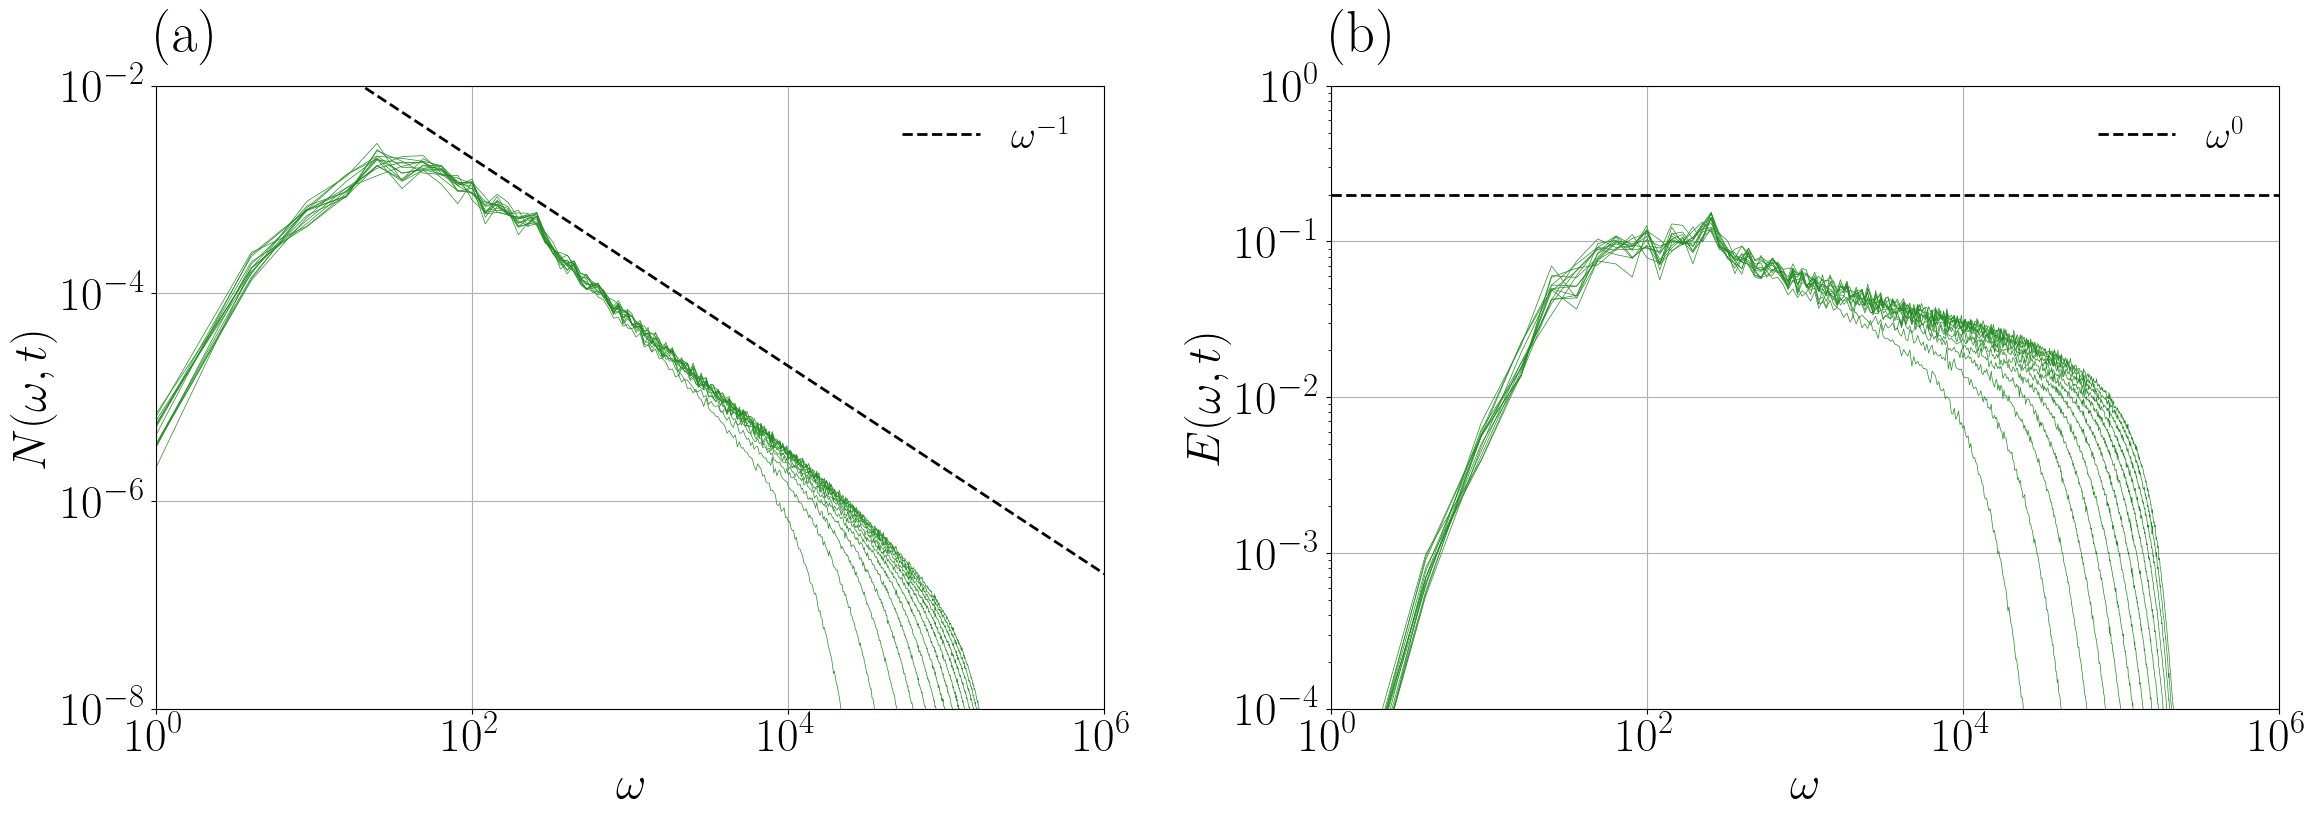

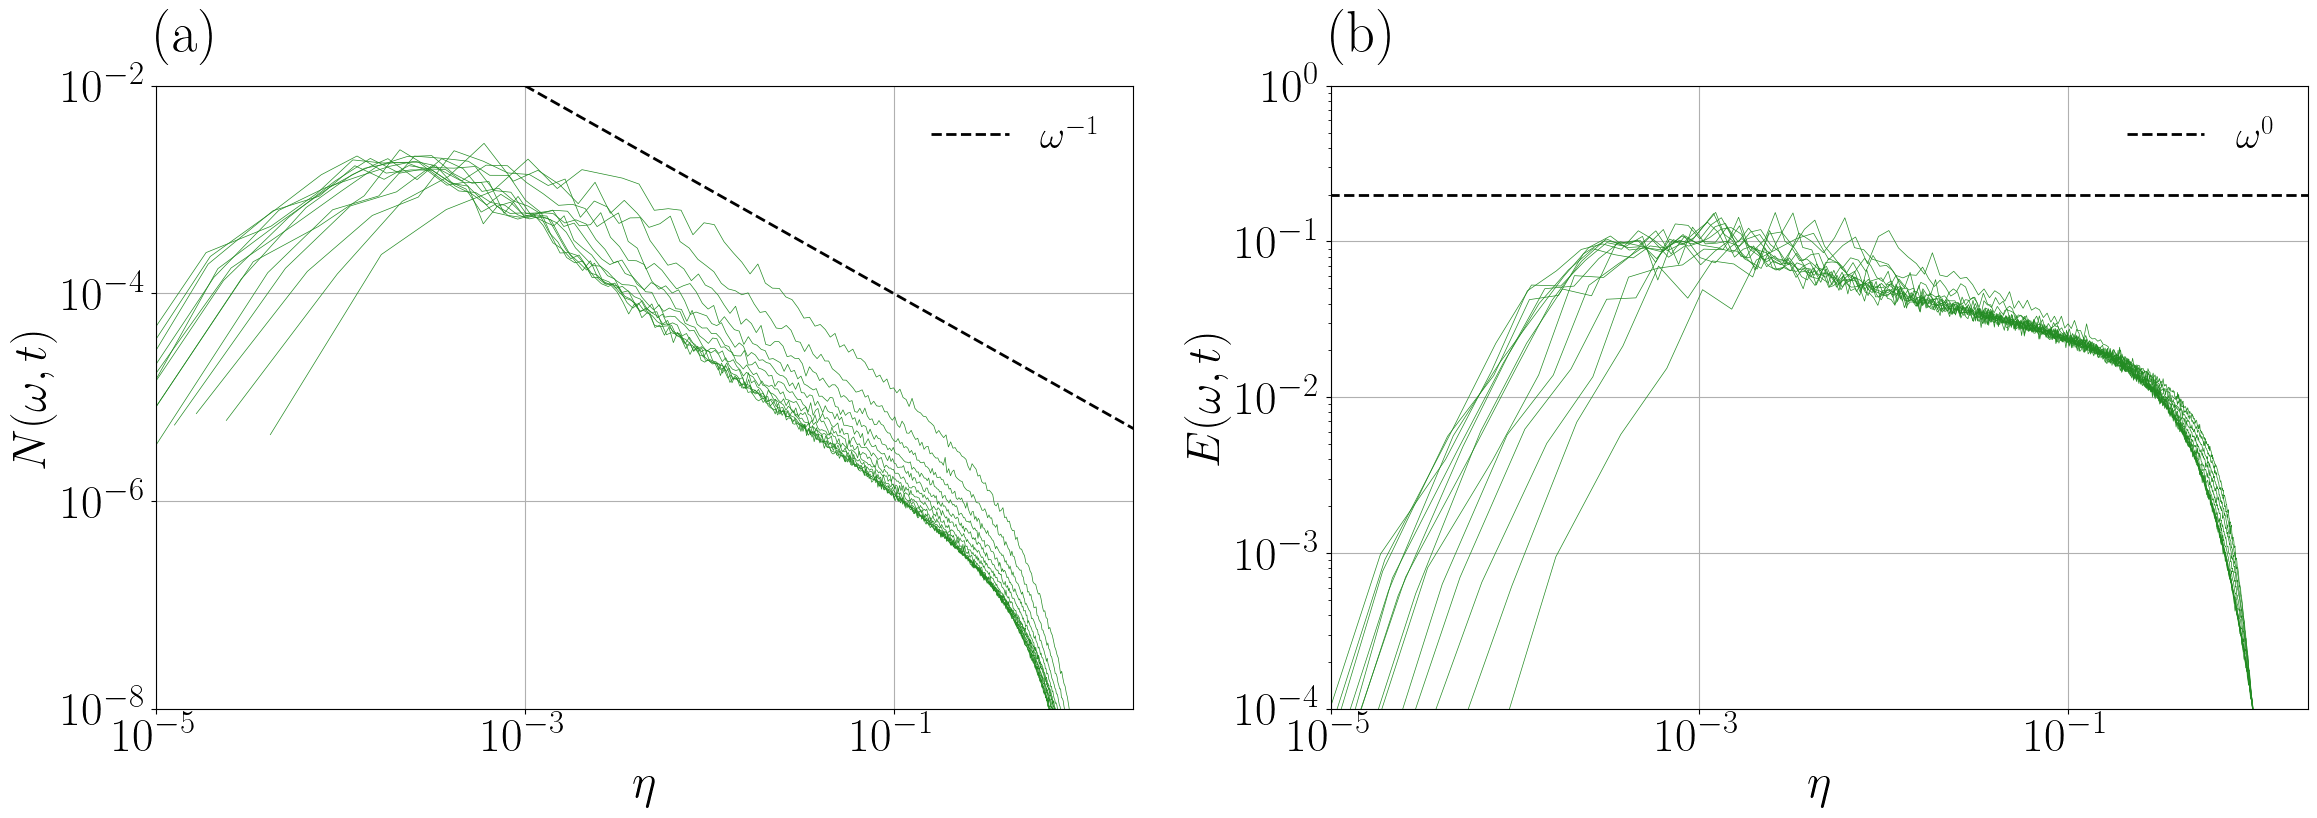

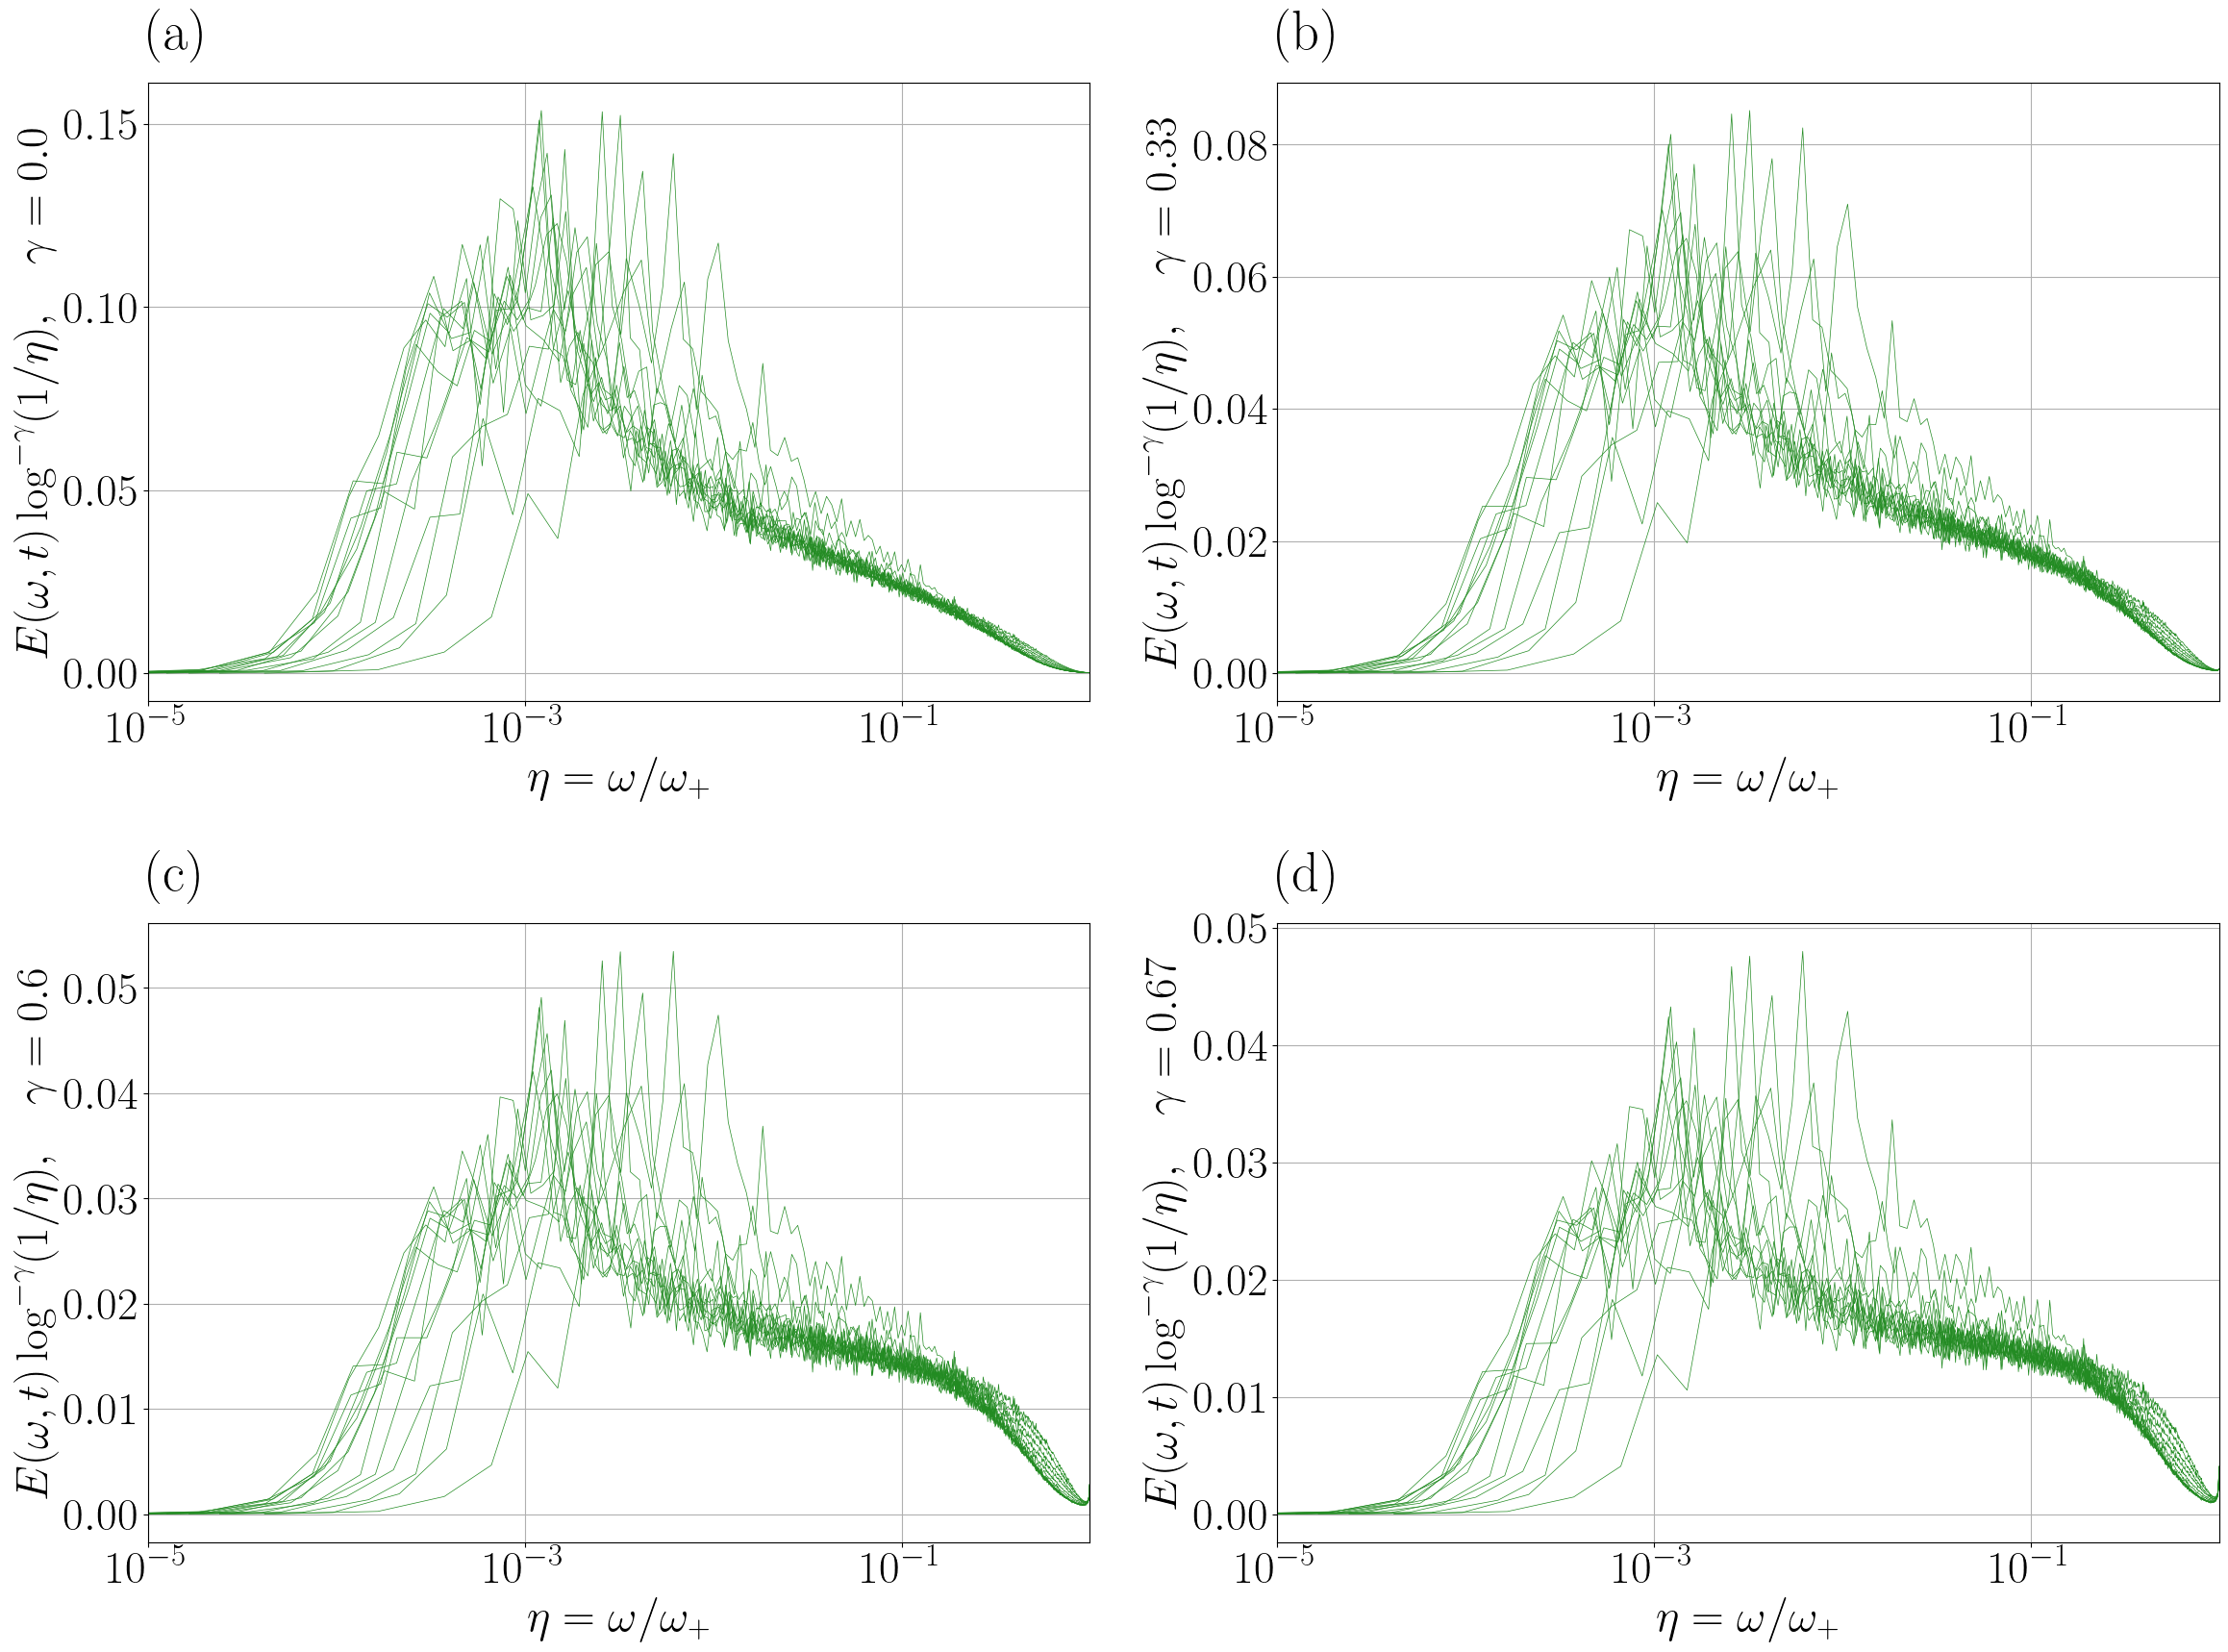

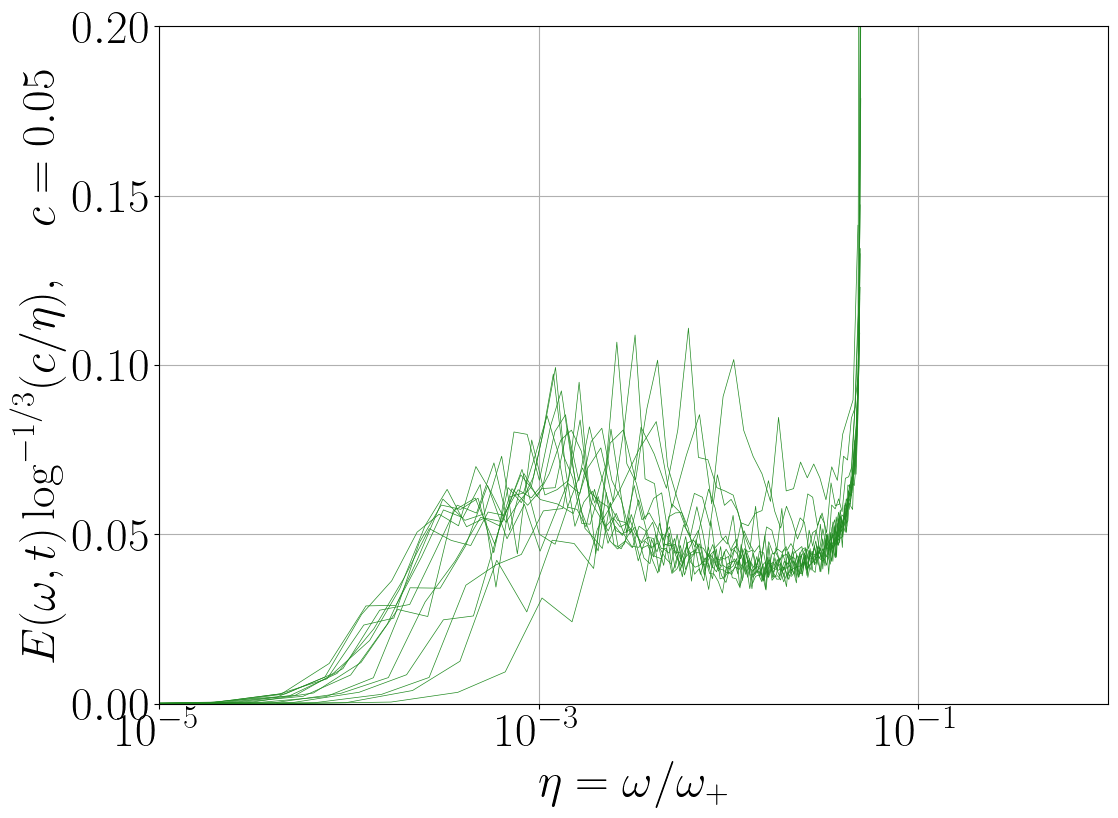

In [ ]:

#DECALRE DATA ARRAYS FOR ANALYSIS

n_k = np.zeros(N)
temp = np.zeros(file_end-file_start+1)
mu =  np.zeros(file_end-file_start+1)
time = np.zeros(file_end-file_start+1)
omega_plus = np.zeros(file_end-file_start+1)


time_data = []
mu_data = []
mu_extrap_data = []
temp_data = []  
temp_extrap_data = []
temp_log_data = []
temp_log2_data = []
c_log2_data = []
omega_plus_data = []
condensate_data = []
N_data =[]
E_data =[]

fig1, axs1 = newfig(1, 2) # spectra in frequency space
fig1b, axs1b = newfig(1, 2) # spectra in self-similar variables
fig2, axs2 = newfig(2, 2) # spectra in self-similar variables
fig2b, axs2b= newfig(1 ,1) # spectra in self-similar variables

for file_num in range(file_start,file_end+1,1):	#loop over data

	time = file_num * dt		# define simulation time
	time_data.append(time)		# records simulation time in a list
 
	n_k = 0.0
	
	#average over ensembles
	#for ensemble_num in range(0,N_ensemble,1):
		#filename = './Selfsimilar_data_May2024/Forced_N=2048_a=4em2/ensemble_%.1d/output/spectrum.%.6d' % (ensemble_num,file_num);
	#	data = np.loadtxt(filename)
	#	n_k += data[:,1]

	#n_k /= N_ensemble   # this is the 2d spectrum  
	#k = data[:,0]		


	filename = '../output/spectrum.%.6d' % (file_num);    
	data = np.loadtxt(filename)
	
	n_k = data[:,1] 
	k = data[:,0]		

	omega, n_omega = convert_k_to_omega(k,n_k)


	if file_num == file_start:			# compute total energy and wave action from initial file
		total_wave_action = np.sum(n_k) * L * L # this is correct
		total_energy =  np.sum(k * k * n_k) * L * L
	
	N_data.append(np.sum(n_k) * L * L)
	E_data.append(np.sum(k * k * n_k) * L * L )
	
 	#calculate omega_plus - the front frequency
	omega_plus = find_omega_plus(omega, n_omega)

	omega_plus_data.append(omega_plus)

	#calculate mu and temp
	####mu, temp = estimate_mu_T(omega, n_omega)
	#mu_extrap, temp_extrap = estimate_mu_T_extrap(omega, n_omega,omega_plus)
	####temp_log = estimate_T_log_right(omega, n_omega,omega_plus)
	####temp_log2, c_log2 = estimate_T_log_right2(omega, n_omega,time)
	####c_log2 = c_log2/time
	####mu_data.append(mu)
	#mu_extrap_data.append(mu_extrap)
	###temp_data.append(temp)
	####condensate_data.append(n_k[0])
	####temp_log_data.append(temp_log)
	####temp_log2_data.append(temp_log2)
	###c_log2_data.append(c_log2)
	#temp_extrap_data.append(temp_extrap)

	##eta = omega * time**(- 1.0 / 3.0)
	##phi = n_omega * time**( 2.0 / 3.0)
	
 
	# define self-similar variable for front
	eta = omega / omega_plus
	#####	phi = n_omega * mu / temp
	gamma = np.array([0.0, 0.333333, 0.6,  0.666667])
	if(file_num % spectrum_freq == 0):
		
		axs1[0].plot(omega, n_omega , linewidth=0.5,c='forestgreen')#,label=r't=%.3f' % round(dt*file_num,4))    		
		axs1[1].plot(omega, omega * n_omega , linewidth=0.5,c='forestgreen')#,label=r't=%.3f' % round(dt*file_num,4))    

		axs1b[0].plot(eta, n_omega , linewidth=0.5,c='forestgreen')#,label=r't=%.3f' % round(dt*file_num,4))    		
		axs1b[1].plot(eta, omega * n_omega , linewidth=0.5,c='forestgreen')#,label=r't=%.3f' % round(dt*file_num,4))  
  
  
		axs2[0,0].plot(eta, omega * n_omega * np.log(1.0/eta)**-gamma[0], linewidth=0.5,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))    		
		axs2[0,1].plot(eta, omega * n_omega * np.log(1.0/eta)**-gamma[1], linewidth=0.5,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))    
		axs2[1,0].plot(eta, omega * n_omega * np.log(1.0/eta)**-gamma[2], linewidth=0.5,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))    
		axs2[1,1].plot(eta, omega * n_omega * np.log(1.0/eta)**-gamma[3], linewidth=0.5,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))   
		a=0.05
		axs2b.plot(eta, omega * n_omega * np.log(a/eta)**-(1.0/3.0), linewidth=0.5,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))   
   
C=0.2	
axs1[0].plot(omega, C*omega**-1.0 , linewidth=2, linestyle='dashed', c='black',label=r'$\omega^{-1}$')   
C=0.2 		
axs1[1].plot(omega, C* omega /omega , linewidth=2, linestyle='dashed', c='black',label=r'$\omega^0$')    

axs1[0].grid()
axs1[0].set_xlabel(r'$\omega$')
axs1[0].set_ylabel(r'$N(\omega,t)$')
axs1[0].set_yscale('log')
axs1[0].set_xscale('log')
axs1[0].set_xlim(1,1.e6)
axs1[0].set_ylim(1.e-8,1e-2)
axs1[0].legend(loc='best', ncol=2)
axs1[0].set_title('(a)',loc='left', pad=24)

axs1[1].grid()
axs1[1].set_xlabel(r'$\omega$')
axs1[1].set_ylabel(r'$E(\omega,t)$')
axs1[1].set_yscale('log')
axs1[1].set_xscale('log')
axs1[1].set_xlim(1,1.e6)
axs1[1].set_ylim(1.e-4,1)
axs1[1].legend(loc='best', ncol=2)
axs1[1].set_title('(b)',loc='left', pad=24)
 
fig1.tight_layout()
fig1.savefig('spectrum_omega.pdf')	


C=0.00001	
axs1b[0].plot(eta, C*eta**-1 , linewidth=2, linestyle='dashed', c='black',label=r'$\omega^{-1}$')   
C=0.2 		
axs1b[1].plot(eta, C* eta / eta , linewidth=2, linestyle='dashed', c='black',label=r'$\omega^0$')    

axs1b[0].grid()
axs1b[0].set_xlabel(r'$\eta$')
axs1b[0].set_ylabel(r'$N(\omega,t)$')
axs1b[0].set_yscale('log')
axs1b[0].set_xscale('log')
axs1b[0].set_xlim(1.e-5,2.e0)
axs1b[0].set_ylim(1.e-8,1e-2)
axs1b[0].legend(loc='best', ncol=2)
axs1b[0].set_title('(a)',loc='left', pad=24)

axs1b[1].grid()
axs1b[1].set_xlabel(r'$\eta$')
axs1b[1].set_ylabel(r'$E(\omega,t)$')
axs1b[1].set_yscale('log')
axs1b[1].set_xscale('log')
axs1b[1].set_xlim(1.e-5,2.e0)
axs1b[1].set_ylim(1.e-4,1)
axs1b[1].legend(loc='best', ncol=2)
axs1b[1].set_title('(b)',loc='left', pad=24)
 
fig1b.tight_layout()
fig1b.savefig('spectrum_eta.pdf')





#axs1.annotate(text=r'Gibbs',xy=(1.1,2.e-2),c='k')
axs2[0,0].grid()
axs2[0,0].set_xlabel(r'$\eta = \omega/\omega_+$')
axs2[0,0].set_ylabel(r'$E(\omega,t)\log^{-\gamma}(1/\eta),\quad \gamma=0.0$')
axs2[0,0].set_yscale('linear')
axs2[0,0].set_xscale('log')
axs2[0,0].set_xlim(1.e-5,1)
#axs1[0,0].set_ylim(0,0.3)
#axs1.legend(loc='best', ncol=2)
axs2[0,0].set_title('(a)',loc='left', pad=24)


axs2[0,1].grid()
axs2[0,1].set_xlabel(r'$\eta = \omega/\omega_+$')
axs2[0,1].set_ylabel(r'$E(\omega,t)\log^{-\gamma}(1/\eta),\quad \gamma=0.33$')
axs2[0,1].set_yscale('linear')
axs2[0,1].set_xscale('log')
axs2[0,1].set_xlim(1.e-5,1)
#axs1[0,1].set_ylim(0,0.2)
#axs1.legend(loc='best', ncol=2)
axs2[0,1].set_title('(b)',loc='left', pad=24)


axs2[1,0].grid()
axs2[1,0].set_xlabel(r'$\eta = \omega/\omega_+$')
axs2[1,0].set_ylabel(r'$E(\omega,t)\log^{-\gamma}(1/\eta),\quad \gamma=0.6$')
axs2[1,0].set_yscale('linear')
axs2[1,0].set_xscale('log')
axs2[1,0].set_xlim(1.e-5,1)
#axs1[1,0].set_ylim(0,0.15)
#axs1.legend(loc='best', ncol=2)
axs2[1,0].set_title('(c)',loc='left', pad=24)


axs2[1,1].grid()
axs2[1,1].set_xlabel(r'$\eta = \omega/\omega_+$')
axs2[1,1].set_ylabel(r'$E(\omega,t)\log^{-\gamma}(1/\eta),\quad \gamma=0.67$')
axs2[1,1].set_yscale('linear')
axs2[1,1].set_xscale('log')
axs2[1,1].set_xlim(1.e-5,1)
#axs1[1,1].set_ylim(0,0.15)
#axs1.legend(loc='best', ncol=2)
axs2[1,1].set_title('(d)',loc='left', pad=24)

fig2.tight_layout()

fig2.savefig('energy_spec_comp_March2025.pdf')



axs2b.grid()
axs2b.set_xlabel(r'$\eta = \omega/\omega_+$')
axs2b.set_ylabel(r'$E(\omega,t)\log^{-1/3}(c/\eta), \quad c=0.05$')
axs2b.set_yscale('linear')
axs2b.set_xscale('log')
axs2b.set_xlim(1.e-5,1)
axs2b.set_ylim(0,0.2)
#axs1.legend(loc='best', ncol=2)
#axs2b.set_title('(d)',loc='left', pad=24)

fig2b.tight_layout()

fig2b.savefig('energy_spec_elephant.pdf')





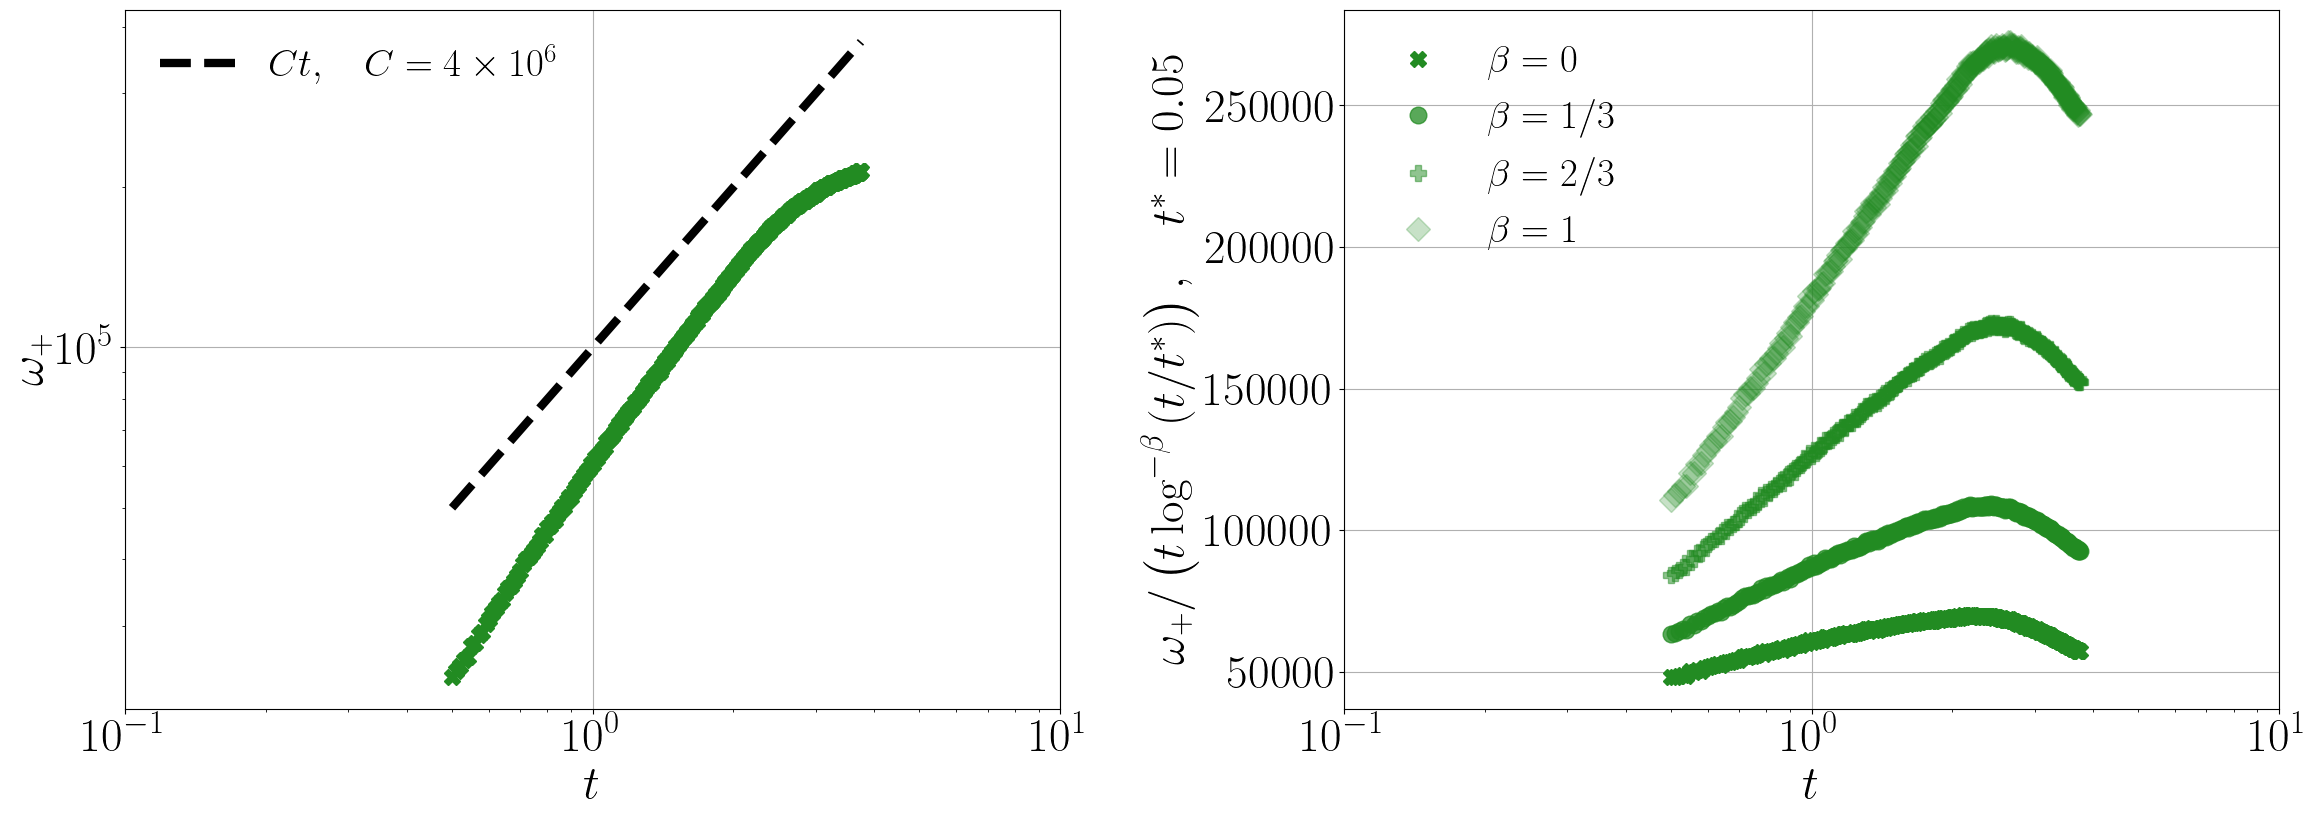

In [162]:
import math
fig2, axs2 = newfig(1, 2)





beta = np.array([0.0, 0.33, 0.67, 1.0])
time_fake = np.arange(0.01, 2.01, step=0.02)
td = np.array(time_data[::2])
od = np.array(omega_plus_data[::2])
C = 1.e5
tt=0.05
axs2[0].plot(td,od, linewidth=0,marker='X',markersize=12,c='forestgreen')   
#axs2[0].plot(time_data,C*np.array(time_data), linewidth=6, linestyle="dashed", c='black', label=r"$Ct,\quad C=0.1$")     
axs2[0].plot(td,C*td, linewidth=6, linestyle="dashed", c='black', label=r"$Ct,\quad C=4\times 10^6$")   
axs2[1].plot(td,od / (td*np.abs(np.log(td/tt))**-beta[0]), linewidth=0,marker='X',markersize=12,c='forestgreen', label=r"$\beta=0$")    
axs2[1].plot(td,od / (td*np.abs(np.log(td/tt))**-beta[1]), linewidth=0,marker='o',markersize=12,c='forestgreen',alpha=0.75, label=r"$\beta=1/3$")   
axs2[1].plot(td,od / (td*np.abs(np.log(td/tt))**-beta[2]), linewidth=0,marker='P',markersize=12,c='forestgreen',alpha=0.5, label=r"$\beta=2/3$")   
axs2[1].plot(td,od / (td*np.abs(np.log(td/tt))**-beta[3]), linewidth=0,marker='D',markersize=12,c='forestgreen',alpha=0.25, label=r"$\beta=1$")   



axs2[0].grid()
axs2[0].set_xlabel(r'$t$')
axs2[0].set_ylabel(r'$\omega_+$')
axs2[0].set_yscale('log')
axs2[0].set_xscale('log')
axs2[0].set_xlim(1.e-1,10)
#axs2[0].set_ylim(1e6,3e6)
axs2[0].legend()


axs2[1].grid()
axs2[1].set_xlabel(r'$t$')
axs2[1].set_ylabel(r'$\omega_+/ \left(t \log^{-\beta}\left(t/t^*\right)\right),\quad t^*=0.05$')
axs2[1].set_yscale('linear')
axs2[1].set_xscale('log')
axs2[1].set_xlim(1.e-1,10)
#axs2[1].set_ylim(1e6,3e7)
axs2[1].legend()

#fig2.tight_layout()

fig2.savefig('omega_plus_March2025.pdf')



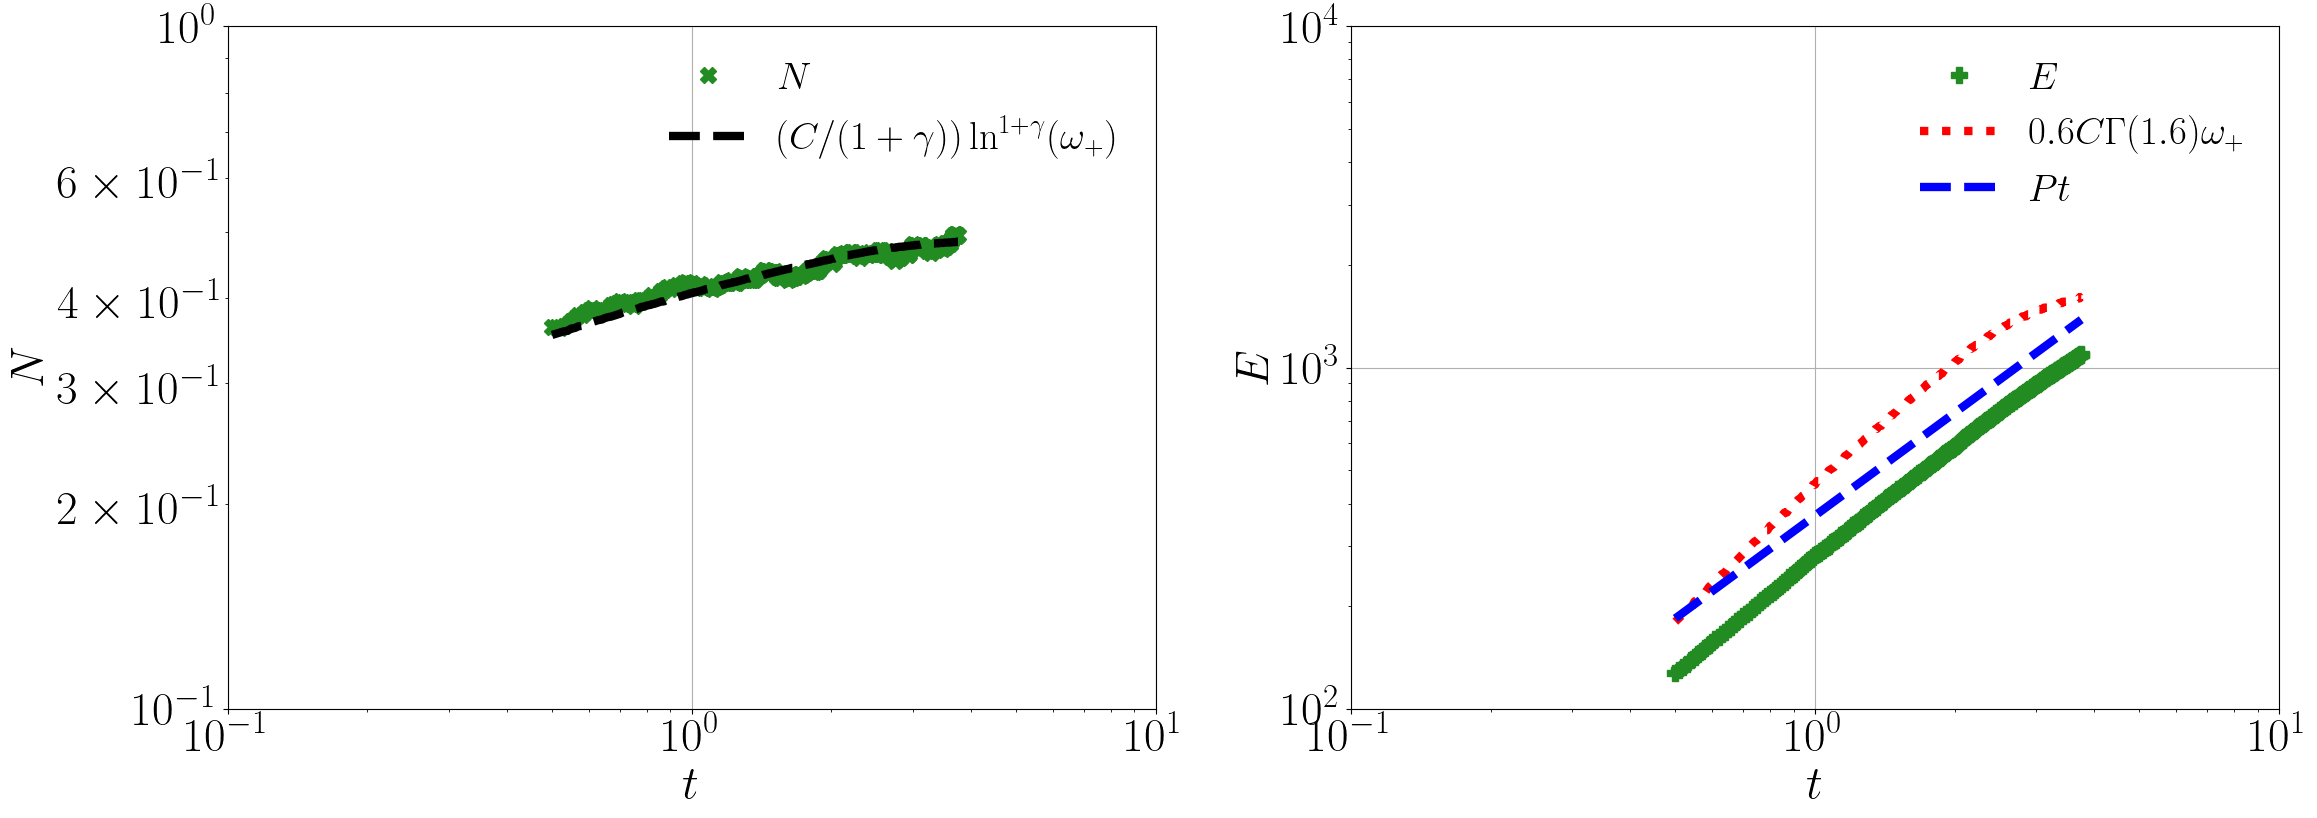

In [ ]:
fig3, axs3 = newfig(1, 2)


# COMMENT: wave action computed in waveaction.***** N = (L^2/Nx*Ny) sum(n_k) [RHS = sum of spectrum n_k]

beta = np.array([0.0, 0.33, 0.67, 1.0])
time_fake = np.arange(0.01, 2.01, step=0.02)
td = np.array(time_data[::2])
od = np.array(omega_plus_data[::2])
Nd = np.array(N_data[::2])
Ed = np.array(E_data[::2])

tt=0.1
axs3[0].plot(td,Nd, linewidth=0,marker='X',markersize=12,c='forestgreen', label=r'$N$')   
axs3[1].plot(td,Ed, linewidth=0,marker='P',markersize=12,c='forestgreen', label=r'$E$')   

#C=  
#axs2.plot(time_fake,C*time_fake, linewidth=6, linestyle="dashed", c='black', label=r"$Ct,\quad C=4\times 10^6$")   

C=0.014
P=368.723 
axs3[1].plot(td,0.6*C*math.gamma(1.6)*od, linewidth=6, linestyle="dotted", c='red', label=r"$0.6C\Gamma(1.6)\omega_+$")   
axs3[1].plot(td,P*td, linewidth=6, linestyle="dashed", c='blue', label=r"$Pt$")   
#C=0.015

gamma=0.6

axs3[0].plot(td,(C/(1.0+gamma))*np.log(od)**(1.0+gamma), linewidth=6, linestyle="dashed", c='black', label=r"$(C/(1+\gamma))\ln^{1+\gamma}(\omega_+)$")   


axs3[0].grid()
axs3[0].set_xlabel(r'$t$')
axs3[0].set_ylabel(r'$N$')
axs3[0].set_yscale('log')
axs3[0].set_xscale('log')
axs3[0].set_xlim(1.e-1,10)
axs3[0].set_ylim(1e-1,1e0)
axs3[0].legend()

axs3[1].grid()
axs3[1].set_xlabel(r'$t$')
axs3[1].set_ylabel(r'$E$')
axs3[1].set_yscale('log')
axs3[1].set_xscale('log')
axs3[1].set_xlim(1.e-1,10)
axs3[1].set_ylim(1e2,1e4)
axs3[1].legend()


fig3.tight_layout()

fig3.savefig('E_N_March2025.pdf')

## Rayleigh-Jeans fit

In [ ]:

#DECALRE DATA ARRAYS FOR ANALYSIS

n_k = np.zeros(N)
temp = np.zeros(file_end-file_start+1)
mu =  np.zeros(file_end-file_start+1)
time = np.zeros(file_end-file_start+1)
omega_plus = np.zeros(file_end-file_start+1)


time_data = []
mu_data = []
mu_extrap_data = []
temp_data = []  
temp_extrap_data = []
temp_log_data = []
temp_log2_data = []
c_log2_data = []
omega_plus_data = []
condensate_data = []


fig1, axs1 = newfig(1, 2)
fig1b, axs1b = newfig(1, 1)
fig2, axs2 = newfig(1, 3)

fig3, axs3 = newfig(1, 2)

fig4, axs4 = newfig(1, 1)

for file_num in range(file_start,file_end+1,1):	#loop over data, every 25 files

	time = file_num * dt		# define simulation time
 
	time_data.append(time)
 
	n_k = 0.0
	
	#average over ensembles
	for ensemble_num in range(0,N_ensemble,1):
		filename = './Selfsimilar_data_May2024/Forced_N=2048_a=4em2/ensemble_%.1d/output/spectrum.%.6d' % (ensemble_num,file_num);
		data = np.loadtxt(filename)
		n_k += data[:,1]

	n_k /= N_ensemble   # this is the 2d spectrum  
	k = data[:,0]		


	#filename = './Forced_N=2048_a=4em2/output/spectrum.%.6d' % (file_num);    
	#data = np.loadtxt(filename)
	
	#n_k = data[:,1] 
	#k = data[:,0]		

	omega, n_omega = convert_k_to_omega(k,n_k)


	if file_num == file_start:			# compute total energy and wave action from initial file
		total_wave_action = np.sum(n_k)
		total_energy = 0.5 * np.sum(k * k * n_k)

	#calculate omega_plus
	omega_plus = find_omega_plus(omega, n_omega)

	omega_plus_data.append(omega_plus)

	#calculate mu and temp
	mu, temp = estimate_mu_T(omega, n_omega)
	#mu_extrap, temp_extrap = estimate_mu_T_extrap(omega, n_omega,omega_plus)
	temp_log = estimate_T_log_right(omega, n_omega,omega_plus)
	temp_log2, c_log2 = estimate_T_log_right2(omega, n_omega,time)
	c_log2 = c_log2/time
	mu_data.append(mu)
	#mu_extrap_data.append(mu_extrap)
	temp_data.append(temp)
	condensate_data.append(n_k[0])
	temp_log_data.append(temp_log)
	temp_log2_data.append(temp_log2)
	c_log2_data.append(c_log2)
	#temp_extrap_data.append(temp_extrap)

	##eta = omega * time**(- 1.0 / 3.0)
	##phi = n_omega * time**( 2.0 / 3.0)
	eta = omega /mu
	phi = n_omega * mu / temp

	if(file_num % spectrum_freq == 0):
		axs1[0].plot(omega, n_omega, linewidth=0.5,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))    						# plots the wave action spectrum (not rescaled)					
		axs1b.plot(omega, omega*n_omega, linewidth=0.5,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))	
		axs1[1].plot(eta, phi, linewidth=0.5,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))					# plots the re-scaled wave action spectrum
		axs4.plot(omega, omega*n_omega, linewidth=0.5,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))
		log_fit2 = temp_log2 / (omega*np.log(c_log2*time/omega)**(-1.0/3.0))
		axs4.plot(omega[kf:], omega[kf:]*log_fit2[kf:],linewidth=1,label=r'$Log$', color='red', linestyle='--')		
		#axs1b.plot(omega[klog_min:klog_max], omega[klog_min:klog_max]*log_fit2[klog_min:klog_max],linewidth=1,label=r'$Log$', color='red', linestyle='--')		

  

  
axs1[0].plot(omega, n_omega, linewidth=2,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))										# plots the wave action spectrum (not rescaled)	
axs1b.plot(omega, omega*n_omega, linewidth=2,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))	
axs1[1].plot(eta, phi, linewidth=2,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))							# plots the re-scaled wave action spectrum

	
Gibbs = (temp/mu) / (1.0 + (omega/mu))																							# define theoretical Gibbs solution
axs1[0].plot(omega[:], Gibbs[:],linewidth=3,label=r'$Gibbs$', color='black', linestyle='--')									# plots the theoretical gibbs solution on wave action spectrum

#Extrap_fit = temp / (omega*np.log(omega_plus/omega)**-0.33+mu)
#axs1[0].plot(omega, Extrap_fit ,linewidth=3,label=r'$Extrap$', color='red', linestyle='--')	


log_fit = temp_log / (omega*np.log(omega_plus/omega)**(-1.0/3.0))
#axs1[0].plot(omega[kf:], log_fit[kf:],linewidth=3,label=r'$Log$', color='blue', linestyle='--')		

log_fit2 = temp_log2 / (omega*np.log(c_log2*time/omega)**(-1.0/3.0))
#axs1[0].plot(omega[kf:], log_fit2[kf:],linewidth=3,label=r'$Log$', color='red', linestyle='--')		




initial=0.0*omega
initial[kf-3:kf+2]=0.025**2  * (1.e-5)**0.5 *2*np.pi
axs1[0].plot(omega, initial, linewidth=2,c='firebrick')																			# plot the initial spectrum on wave action spectrum


#axs1.annotate(text=r'Gibbs',xy=(1.1,2.e-2),c='k')
axs1[0].annotate(text='$t=0$',xy=(wf-120000,1.e-3),c='firebrick')
axs1[0].grid()
axs1[0].set_xlabel(r'$\omega$')
axs1[0].set_ylabel(r'$N(\omega,t)$')
axs1[0].set_yscale('log')
axs1[0].set_xscale('log')
axs1[0].set_xlim(1,(1024*1.5)**2)
axs1[0].set_ylim(1.e-10,1.e0)
#axs1.legend(loc='best', ncol=2)
axs1[0].set_title('(a)',loc='left', pad=24)



Gibbs = (temp/mu) / (1.0 + (omega/mu))																							# define theoretical Gibbs solution
axs1b.plot(omega[:], omega*Gibbs[:],linewidth=3,label=r'$Gibbs$', color='black', linestyle='--')									# plots the theoretical gibbs solution on wave action spectrum

#Extrap_fit = temp / (omega*np.log(omega_plus/omega)**-0.33+mu)
#axs1[1].plot(omega[:], omega[:]*Extrap_fit[:],linewidth=3,label=r'$Extrap$', color='red', linestyle='--')	


##log_fit = temp_log / (omega*np.log(omega_plus/omega)**(-1.0/3.0))
##axs1b[0].plot(omega[kf:], omega[kf:]*log_fit[kf:],linewidth=3,label=r'$Extrap$', color='blue', linestyle='--')		

log_fit2 = temp_log2 / (omega*np.log(c_log2*time/omega)**(-1.0/3.0))
axs1b.plot(omega[klog_min:klog_max], omega[klog_min:klog_max]*log_fit2[klog_min:klog_max],linewidth=3,label=r'$Log$', color='red', linestyle='--')		
print("Tlog2 = ", temp_log2 , " clog2 = ", c_log2 )


initial=0.0*omega
initial[kf-3:kf+2]=0.025**2  * (1.e-5)**0.5 *2*np.pi
axs1b.plot(omega, initial, linewidth=2,c='firebrick')																			# plot the initial spectrum on wave action spectrum


#axs1.annotate(text=r'Gibbs',xy=(1.1,2.e-2),c='k')
axs1b.annotate(text='$t=0$',xy=(wf-120000,1.e-3),c='firebrick')
axs1b.grid()
axs1b.set_xlabel(r'$\omega$')
axs1b.set_ylabel(r'$\omega N(\omega,t)$')
axs1b.set_yscale('log')
axs1b.set_xscale('log')
axs1b.set_xlim(1.e4,(1024*1.5)**2)
axs1b.set_ylim(1.e-2,1.e0)
#axs1.legend(loc='best', ncol=2)
#axs1b.set_title('(b)',loc='left', pad=24)


fig1b.tight_layout()

fig1b.savefig('spectrum_fit_forced.pdf')







eta = np.arange(1.e-5,1.e5,0.01)
Gibbs_fit = 1.0 / (eta+1.0)
axs1[1].plot(eta, Gibbs_fit,linewidth=3,label=r'$Gibbs$', color='black', linestyle='--')

#Extrap_fit = 1.0 / (eta*np.log(omega_plus/(mu*eta))**-0.33+1.0)
#axs1[2].plot(eta[:], Extrap_fit[:],linewidth=3,label=r'$Extrap$', color='red', linestyle='--')


####log_fit = (templogd[-1]/tempd[-1])/ (eta*np.log(omega_plus/(mu*eta))**(-1.0/3.0))
####axs1[2].plot(eta[kf:], log_fit[kf:],linewidth=3,label=r'$Extrap$', color='blue', linestyle='--')		



#axs2.annotate(text=r'Anomalous Gibbs: $\frac{1}{\eta+1}$',xy=(1.1e-5,2.e0),c='k')
#axs2.annotate(text='$\leftarrow f_0$',xy=(wf,1e-4),c='firebrick')
axs1[1].grid()
axs1[1].set_xlabel(r'$\eta:=\omega/\mu(t)$')
axs1[1].set_ylabel(r'$\phi:=(\mu/T)N(\omega,t)$')
axs1[1].set_yscale('log')
axs1[1].set_xscale('log')
#axs2.set_xlim(1e-5,1e4)
axs1[1].set_ylim(1.e-8,1.e1)
#axs1.legend(loc='best', ncol=2)

axs1[1].set_title('(b)', loc='left',pad=24)






fig1.tight_layout()

fig1.savefig('spectrum_forced.pdf')


##################################################################################################################
#fit between t=0.25 and t=0.5
tlow = 50 - 30
thigh = 120 - 30


td = np.array(time_data)
tempd = np.array(temp_data)
templogd = np.array(temp_log_data)
templog2d = np.array(temp_log2_data)
mud = np.array(mu_data)
# plot mu vs t
axs2[0].scatter(time_data, mu_data,linewidth=3, color='b', linestyle='-')

# fitting for c1* t^{1} * exp( -c2 * t^{3/4})
[c1,c2], pcov = curve_fit(exp3_function,td[tlow:thigh], mud[tlow:thigh,0])
print('c1 = ', c1, 'c2 = ', c2)

axs2[0].plot(td, c1*td * np.exp(-c2* td**(3.0/4.0)),linewidth=3,label=r'$c_1te^{-c_2 t^{3/4}}$', color='black', linestyle='--')


# plot for T vs t
axs2[1].scatter(time_data, temp_data,linewidth=3, color='r', linestyle='-')
# fitting for c* t^{0}
c, pcov = curve_fit(constant_function,td[tlow:thigh], tempd[tlow:thigh,0])
print('c = ', c)
axs2[1].plot(td, c*td/td,linewidth=3,label=r'$c_1$', color='black', linestyle='--')


# plot for T_log vs t
#axs2[2].scatter(td, templogd,linewidth=3, color='r', linestyle='-',label=r'$T_{\gg}^{\rm log}$')
axs2[2].scatter(td, templog2d,linewidth=3, color='orange', linestyle='-',label=r'$T_{\gg}^{\rm log}$')
# fitting for c * t
c, pcov = curve_fit(constant_function,td[tlow+20:thigh], templog2d[tlow+20:thigh])
axs2[2].plot(td[tlow+20:], c*td[tlow+20:]/td[tlow+20:],linewidth=3,label=r'$c_1$', color='black', linestyle='--')
print('c = ', c)


axs2[0].grid()
#axs2.set_xlabel(r'$\eta:=\omega/\mu(t)$')
axs2[0].set_ylabel(r'$\mu$')
axs2[0].set_xlabel(r'$t$')
axs2[0].set_yscale('log')
axs2[0].legend(loc='best', ncol=2)
axs2[0].set_xlim(0,1)
axs2[0].set_title('(a)', loc='left',pad=24)

axs2[1].grid()
axs2[1].set_ylabel(r'$T$')
axs2[1].set_xlabel(r'$t$')
axs2[1].set_xscale('linear')
axs2[1].set_yscale('linear')
axs2[1].legend(loc='best', ncol=2)
axs2[1].set_xlim(0,1.000001e0)
axs2[1].set_ylim(0,5e-1)
axs2[1].set_title('(b)', loc='left',pad=24)

axs2[2].grid()
axs2[2].set_ylabel(r'$c_1$')
axs2[2].set_xlabel(r'$t$')
axs2[2].set_xscale('linear')
axs2[2].set_yscale('linear')
axs2[2].legend(loc='best', ncol=2)
axs2[2].set_xlim(0,1.000001e0)
axs2[2].set_ylim(0,2.e-1)
axs2[2].set_title('(c)', loc='left',pad=24)
fig2.tight_layout()

fig2.savefig('mu_T_forced.pdf')

##################################################################################################################


# plot for omega_+ vs t

opd = np.array(omega_plus_data)

axs3[0].scatter(td, opd,linewidth=3, color='g', linestyle='-',label=r'$\omega_+$')
axs3[0].scatter(td, c_log2_data*td,linewidth=3, color='orange', linestyle='-',label=r'$c_{\rm log}t$')

# fitting for c * t
c, pcov = curve_fit(constant_function,td[tlow:thigh], td[tlow:thigh]**(-1.0)*opd[tlow:thigh])
print('c = ', c)

axs3[0].plot(td, c*td,linewidth=3,label=r'$c_1 t$', color='black', linestyle='--')


# plot N(omega =0)  vs t
axs3[1].scatter(time_data, condensate_data,linewidth=3, color='orange', linestyle='-')

# fitting for c * t^{-1} * Exp(c2 * t^{3/4})
[c1,c2], pcov = curve_fit(exp4_function,td[tlow:thigh], condensate_data[tlow:thigh])
print('c1 = ', c1, 'c2 = ', c2)

axs3[1].plot(td, c1*td**(-1.0)*np.exp(c2 * td**(3.0/4.0)),linewidth=3,label=r'$c_1t^{-1}e^{c_2 t^{3/4}}$', color='black', linestyle='--')


axs3[0].grid()
#axs2.set_xlabel(r'$\eta:=\omega/\mu(t)$')
axs3[0].set_ylabel(r'$\omega_+$')
axs3[0].set_xlabel(r'$t$')
axs3[0].set_xscale('log')
axs3[0].set_yscale('log')
axs3[0].legend(loc='best', ncol=2)
axs3[0].set_xlim(1e-1,1.000001e0)
axs3[0].set_title('(a)', loc='left',pad=24)

axs3[1].grid()
axs3[1].set_ylabel(r'$N_{\omega=0}$')
axs3[1].set_xlabel(r'$t$')
axs3[1].set_xscale('log')
axs3[1].set_yscale('log')
axs3[1].set_xlim(1e-1,1.00001e0)
axs3[1].set_ylim(1.e-7,1e0)
axs3[1].set_title('(b)', loc='left',pad=24)


axs3[1].legend(loc='best', ncol=2)

fig3.tight_layout()

fig3.savefig('parameters_forced.pdf')


#####################################################


#axs1.annotate(text=r'Gibbs',xy=(1.1,2.e-2),c='k')
axs4.annotate(text='$t=0$',xy=(wf-120000,1.e-3),c='firebrick')
axs4.grid()
axs4.set_xlabel(r'$\omega$')
axs4.set_ylabel(r'$\omega N(\omega,t)$')
axs4.set_yscale('log')
axs4.set_xscale('log')
axs4.set_xlim(1.e4,(1024*1.5)**2)
axs4.set_ylim(1.e-2,1.e0)
#axs1.legend(loc='best', ncol=2)
#axs4.set_title('(b)',loc='left', pad=24)

#fig4.tight_layout()

#fig4.savefig('spectrum_fit_forced.pdf')
